In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from dataprocessor import *

/Users/feifang/miniconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/feifang/miniconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/feifang/miniconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/feifang/miniconda3/envs/sno

## Load test set

In [3]:
processor = ImdbProcessor('../imdb-data')
test_examples = processor.get_test_examples()

In [4]:
labels_test_str = [example.label for example in test_examples]
labels_test = [1 if l == 'pos' else 0 for l in labels_test_str]

In [17]:
models = {'og': '12092031',
          'sd800':'12090849',
          'wd02':'12101010',
          'nwd00':'12100331',
          'wd03':"12130518"
         }

In [18]:
def read_tsv(input_file):
    """Reads a tab separated value file."""
    with tf.gfile.Open(input_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        lines = []
        for line in reader:
            line = [float(l) for l in line]
            lines.append(line)
    return lines

In [19]:
def get_probs(train_set):
    model_id = models[train_set]
    pred_dir = 'gs://cs229-checkpoints/imdb/{}/{}'.format(train_set, model_id)
    pred_file = os.path.join(pred_dir, "preds_on_test.tsv")
    pred_probs = read_tsv(pred_file)
    return np.asarray(pred_probs)

In [20]:
def get_preds(probs):
    return np.argmax(probs, axis=1)

In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_accuracy(preds):
    return accuracy_score(labels_test, preds)

def get_auc(probs):
    pos_probs = probs[:, 1]
    return roc_auc_score(labels_test, pos_probs)

## Load predictions

In [22]:
probs_dict = {}
preds_dict = {}
for train_set in models.keys():
    probs_dict[train_set] = get_probs(train_set)
    preds_dict[train_set] = get_preds(probs_dict[train_set])

## Accuracies

In [23]:
for train_set in preds_dict.keys():
    print("Accuracy on {}: {}".format(train_set, get_accuracy(preds_dict[train_set])))

Accuracy on og: 0.8838842975206611
Accuracy on sd800: 0.8229338842975207
Accuracy on wd02: 0.7947933884297521
Accuracy on nwd00: 0.7318595041322314
Accuracy on wd03: 0.8150826446280992


## AUC

In [24]:
for train_set in probs_dict.keys():
    print("AUC on {}: {}".format(train_set, get_auc(probs_dict[train_set])))

AUC on og: 0.9454294959360698
AUC on sd800: 0.9129875759852468
AUC on wd02: 0.8788777884024315
AUC on nwd00: 0.8069924936821256
AUC on wd03: 0.8970975787173007


# Plot

In [13]:
import matplotlib.pyplot as plt

In [14]:
ds_map = {i: 'SD' + str(i) for i in [800, 1600, 3200, 6400, 12800]}
ds_map[25000] = 'OG'

In [15]:
#xs = ['OG','SD12800','SD6400','SD3200','SD1600','SD800']
accs = [0.8229338842975207, 0.8538843, 0.8645868, 0.8635537, 0.87975204, 0.8838842975206611]

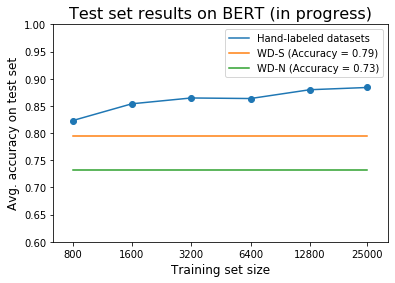

In [16]:
import numpy as np
xs = [ds_size / 800 for ds_size in list(ds_map.keys())]
plt.xscale("log", basex=2)
plt.ylim(0.6,1.)
plt.xlim(0.8, 40)
plt.xticks(xs, list(ds_map.keys()))
plt.scatter(xs, accs)
plt.plot(xs, accs, label='Hand-labeled datasets')
plt.xlabel("Training set size", fontsize=12)
plt.ylabel("Avg. accuracy on test set", fontsize=12)
plt.plot(np.linspace(1, 25000/800, 30), [0.7947933884297521] * 30, label="WD-S (Accuracy = 0.79)")
plt.plot(np.linspace(1, 25000/800, 30), [0.7318595] * 30, label="WD-N (Accuracy = 0.73)")
plt.title("Test set results on BERT (in progress)", fontsize=16)
plt.legend()